# Abstract - Summary

In this project I will fetch data about businesses from the yelp API within 15 miles of UMBC.  In the first section I will explain the business problem and corresponding machine learning problem to describe the question at hand and why it is important.  In the following Data Dictionary section I will show the process of using the yelp API in order to retreive the data back as json and parsing it into a csv which is then loaded as a pandas dataframe.  This leads to the next section to understand and visualize the data where I perform some analysis on the pandas dataframe to find stats and information in the data for problems such as good cheap restaraunts and how close they are to UMBC.  Next is the data prep section where I will perform some feature engineering in attempt to get the best possible results from the machine learning model which is created in the section thereafter.  Following is a section on model selection and evaluation which describes the algorithms and how I determine if the model results are successful.  Lastly, I will describe the conclusions, interpretations, limitations, and later work in the final section of the report.

SHARE MOST IMPORTANT RESULT


# Business Problem and Corresponding Machine Learning Problem

UMBC and college campuses in general draw a lot of people to one area which presents a large opportunity for the surrounding businesses.  The type of people that gather at college campuses tend to me similar in certain ways, but very different in others.  For example, the bulk of the people there are most likely in the age range of 18-24, interested in going out around campus with friends, and in most cases not necessarily financially well off as they are paying tuition with minimal income.  On the other hand, the people who gather there may be from anywhere across the world; with different cultures, religions, and culinary practices.

With that, there may be a pattern in what types a businesses are most successful around a college campus.  Perhaps they tend to be cheaper places that fit all kinds of cultures.  The machine learning problem at hand here is: can we detect hidden groups or patterns in businesses of interest to college students, in particular shops and restaurants, within 15 miles of UMBC to see the diversity of them and determine if there are some that should that are redundant and should be gotten rid of and any opportunity for new restaurants and or shops that would fill the void of what is not already there?  For example, say I am looking to start a new business and I want to know if it has a good chance of being successful.  Perhaps there is a void in a certain location for a certain type of business that would be hugely successful if I start it.  In the scenario the stakeholder is the me as the prospective business owner.  And what the stakeholder is asking is what type of business could potentially fill a missing void and be successful as it would be in demand.  In a secondary scenario, there may be cases where some businesses are redundant and with too many of the same businesses, they don't have enough demand to do well.  In this case the stakeholder would be the current business owner struggling and helping him/her see that their business is redundant and potentially offering them help on how to potentially change to be more successful.

# Data Dictionary

In this section we have the code for receiving the data, cleaning it, and putting it into a csv file.

In [1]:
#imports
import requests #for making the we requests
import json  #for loading the text to json
from configparser import ConfigParser  #for loading the API key from a config file
import csv #for writing to a csv
import pandas as pd #for data analysis
from tabulate import tabulate #for creating tables
from sklearn.preprocessing import normalize #for normalizing the data

For the next code block below, it will not necessarily need to be changed in order to run properly, but the runner of this notebook will need to place a secret.cfg file two directories up with an auth and token section - these are from yelp - to be authenticated upon each call.  You may create a yelp account here: https://www.yelp.com/developers.  And once an account is created, create an app.  Once the app is created, from the manage app page there will be a Client ID and API key.  Put the Client Id in a 'auth' section of the secret.cfg file, and the API key in the 'token' section of the same file.

In [2]:
#load the API key from a file a few directories up so that it is not stored in the git repo.
#this code will not need to be changed in order to run properly, but the runner of this notebook will need to
#place a secret.cfg file two directories up with an auth and token section - these are from yelp - to be authenticated
#upon each call
config = ConfigParser()
config.read('../../secret.cfg')
token = config.get('auth', 'token')

#set it as the header
headers = {'Authorization': 'Bearer %s' % token}

In [3]:
#set the url to the yelp API
url='https://api.yelp.com/v3/businesses/search'
 
#From the yelp API docs, there are a bunch of categories.  I went through and found ones that I believed would
#be of interest to college students.
interestingCategories = ["atvrentals", "airsoft", "amateursportsteams","amusementparks","aquariums","archery","axethrowing","badminton","baseballfields","beaches","bicyclepaths", "bikerentals", "bikeparking", "boating", "bobsledding", "bocceball", "bowling", "bungeejumping", "climbing", "daycamps", "discgolf", "diving", "escapegames", "fencing", "fishing", "fitness", "flyboarding","gokarts","golf","gun_ranges","hiking","horsebackriding","jetskis","lasertag","mini_golf","mountainbiking","paddleboarding","paintball","parks","playgrounds","races","rafting","recreation","sailing","football","swimmingpools","tennis","skatingrinks","arcades","galleries","bingo","movietheaters","eatertainment","festivals","musicvenues","theater","social_clubs","stadiumsarenas","ticketsales","wineries","acnetreatment","barbers","spas","massage","bicycles","acaibowls", "backshop", "bagels", "bakeries", "beer_and_wine", "bento", "beverage_stores", "breweries", "bubbletea", "butcher", "csa", "chimneycakes", "churros", "cideries", "coffee", "coffeeteasupplies", "coffeeroasteries", "convenience", "cupcakes", "customcakes", "delicatessen", "desserts", "distilleries", "diyfood", "donairs", "donuts", "empanadas", "farmersmarket", "fishmonger", "fooddeliveryservices", "foodtrucks",  "friterie", "gelato","grocery","hawkercentre", "honey","icecream","importedfood","intlgrocery","internetcafe","jpsweets","juicebars","kiosk", "kombucha","meaderies", "milkshakebars","gluhwein", "nasilemak","organic_stores", "panzerotti", "eltern_cafes", "cakeshop","piadinapoke", "pretzels", "shavedice", "shavedsnow", "smokehouse", "gourmet", "streetvendors", "sugarshacks", "tea", "tortillas", "wineries","adultentertainment","barcrawl","bars","beergardens","clubcrawl","coffeeshops","comedyclubs","danceclubs","dancerestaurants","karaoke","musicvenues","pianobars","poolhalls","petstore","restaurants","shopping"]

In the below block of code is nested loops.  The outer goes through each category in the list of categories that I believed would be interesting to college students.  The reason I spent the time going through all these groups rather than just simply seraching for terms like 'food' or 'fun' is because of a limitation with the yelp API.  For any one particular query, a maximum of 1,000 businesses may be obtained with it (offset cannot be used above 1,000) and so with breaking the calls down to more specific categories, that minimizes the number of calls that return a number of businesses greater than 1,000 which results in more data for us both in numbers and of higher quality as less is missing.

In [4]:
businesses = []  #start with empty array of businesses to build on
FIFTEEN_MILES = 24140 #this is 15 miles, measured in meters
MAX_RETURN_SIZE = 50 #the max yelp will return is 50 businesses at a time

for category in interestingCategories:  #for each category of interest...
    #set the params and make the initial request
    params = {'categories':category, 'location':'1000 Hilltop Circle Baltimore, MD 21250', 'radius': FIFTEEN_MILES, 'limit':MAX_RETURN_SIZE, 'sort_by':'rating'}
    req=requests.get(url, params=params, headers=headers)
    
    #check the status code of the response
    print('The status code is {}'.format(req.status_code))
    if req.status_code != 200:
        continue  #if it failed... just continue without breaking the process
    resp = json.loads(req.text) #load the text of the response to json
    offset = 0  #use the offset to page through the results
    numToGet = resp["total"]
    numReceived = len(resp["businesses"])
    for business in resp["businesses"]:  #create column of category for each business to save what it was found on
        business["category"] = category
    businesses.extend(resp['businesses']) #extend the business array with the businesses
    while numToGet > numReceived: #while there are still more to get...
        offset += len(resp["businesses"])
        if offset == 1000: #stop at 1000 - this is the limit set by yelp
            break
        #set the params again this time with the updated offset
        params = {'category':category, 'location':'1000 Hilltop Circle Baltimore, MD 21250', 'radius': 24140, 'limit':50, 'offset':offset, 'sort_by':'rating'}
        req=requests.get(url, params=params, headers=headers) #make the request again
        # proceed only if the status code is 200
        print('The status code is {}'.format(req.status_code))
        resp = json.loads(req.text) #load the text to json
        if 'businesses' in resp: #check for the businesses in the output
            numReceived += len(resp["businesses"]) #increase the num received by what we got
            for business in resp["businesses"]:
                business["category"] = category #add the category for these as well
        else:
            break
        businesses.extend(resp['businesses']) #extend the businesses array with the found businesses

The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status 

In [5]:
#parse the results and write to a csv file
with open('../data/scrapedData.csv', mode='w') as employee_file: #open the csv file...
    writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL) #create the writer...
    #write the first row with to be the headers
    writer.writerow(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'latitude', 'longitude', 'distance', 'address', 'price', 'is_delivery', 'is_pickup', 'category'])
    for business in businesses: #loop through and write a row per business
        price = None #find the info for each business
        categoriesList = []
        categories = None
        isPickup = False
        isDelivery = False
        if 'price' in business:
            price = len(business['price']) #price represented as $, $$, $$$, $$$$ - convert to numeric to be used with sorting
        if 'categories' in business:
            for category in business['categories']:  #save the category titles in one string
                categoriesList.append(category['title'])
            categories = ", ".join(categoriesList)
        if 'delivery' in business['transactions']:
            isDelivery = True
        if 'pickup' in business['transactions']:
            isPickup = True
        writer.writerow([business["id"], business["alias"], business["name"], business["image_url"], business["is_closed"], business["url"], business["review_count"], categories, business["rating"], business["coordinates"]["latitude"], business["coordinates"]["longitude"], business["distance"], " ".join(business["location"]["display_address"]), price, isDelivery, isPickup, business["category"]])

Now we have the scraped data saved in the ../data directory as a csv file.  It can be loaded from any notebook and we will load it in the next section to perform the analysis on it using a pandas dataframe.

# Understanding and Visualizing the Data

The question/ problem at hand here is finding hidden groups or patterns in shops/restaurants around UMBC in hopes of determining if there are some redundant and not needed or some that have a great chance to be successful.  The businesses surrounding UMBC are our customer, and the more they know about how much opportunity that they have to be successful, the better.  Existing businesses, if they are struggling want to know their competition and how they might change to be successful.  Potential new start-up businesses want to be able to gauge the opportunity to be able to know if their type of business has a solid chance of being successful or not based on what already exists.

In this section I will do some analysis on the pandas dataframe to look for trends that might show some of the patterns in businesses around UMBC.  Our target audience is executives of the surrounding businesses or prospective business owners.  I look for patterns such as the price range of the majority of businesses, their proximity to UMBC, and convenience to see the patterns of what kinds of businesses are more fequent around the university.  This is not to say that all businesses have to fit the trend.  For example, perhaps there are the percentage of college students who are well off financially and can afford to go to a nice restaurant - these nicer restaurants have an opportunity to be successful, but we would expect to see more cheaper restaurants than expensive as the percentage of college students who can afford high prices is likely smaller.

The process for answering this question begins with exploring stats/ information about trends in the restaurants and shops around UMBC that are attractive to prospective students.  This will give us an initial idea of what some trends in the features we can cluster based on look like.  It is an initial attempt based on intuition and if there was more time to carry the project forward, more experimentation and research could be done on what students look for in local businesses around college and I could attack those categories in the exploration.

The first analysis I will do is on the closeness of some of the restaurants and shops around UMBC:


In [6]:
#read in the raw csv file
df = pd.read_csv("../data/scrapedData.csv", encoding= 'utf-8')

#some businesses could be part of the two different categories - drop the duplicates
df = df.drop_duplicates()

In [7]:
#create some dataframes that will be used throughout for analysis to avoid duplication
restaurants = df.loc[df["category"] == "restaurants"] # get df with all the restaurants
shops = df.loc[df["category"] == "shopping"] # get df with all the shops

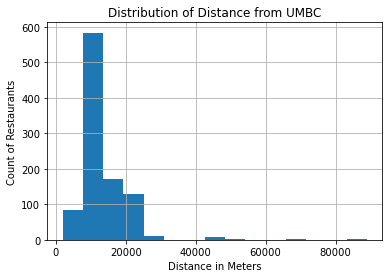

In [8]:
#we can look for trends in the data... how close are the bulk of the restaurants around UMBC?
hist = restaurants.hist(column="distance", bins=15) #histogram of the distance column to see the distribution

#set the labels
for ax in hist.flatten():
    ax.set_xlabel("Distance in Meters")
    ax.set_ylabel("Count of Restaurants")
    ax.set_title("Distribution of Distance from UMBC")

Based on the histogram above, we see that the data is skewed right, showing that the majority of restaurants are within 10,000 meters (~6 miles) of campus.  This takeaway is that the bulk of restaurants within 15 miles of UMBC are within roughly 6 miles of campus.  This could potentially tell us that if a student is going to make the effort to travel outside the 6 miles from campus, any restaurant outside that range might have to be a bit more special or unique to make the trip worth it.

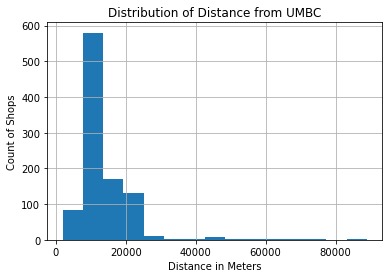

In [17]:
#we can look for trends in the data... how close are the bulk of the shops around UMBC?
hist = shops.hist(column="distance", bins=15)

for ax in hist.flatten():
    ax.set_xlabel("Distance in Meters")
    ax.set_ylabel("Count of Shops")
    ax.set_title("Distribution of Distance from UMBC")

We can do the same, but this time for shops - with many students living on campus or off campus but close to it, it is important to have convenient stores near by for the daily essentials.  Based on the histogram above, we see again that the majority of stores are also within the about 10,000 meters/6 miles away.  This leads us to the same interpretation as with the restuarants - if a student is going to make the effort to travel outside the roughly 6 mile range it likely is going to have to be something that they can not get within the 6 mile range.

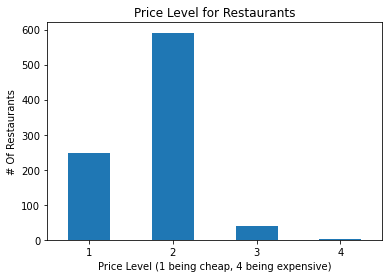

In [18]:
#we can look for trends in the data... what level of prices are the restaurants around UMBC?
restaurants["price"].value_counts().reindex([1,2,3,4]).plot(kind='bar', title="Price Level for Restaurants", ylabel="# Of Restaurants", xlabel="Price Level (1 being cheap, 4 being expensive)", rot=0);

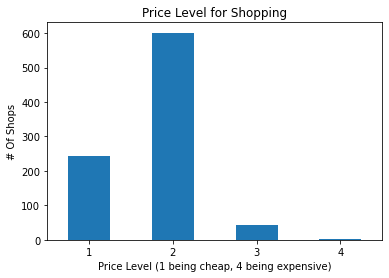

In [19]:
#we can look for trends in the data... what level of prices are the restaurants around UMBC?
shops["price"].value_counts().reindex([1,2,3,4]).plot(kind='bar', title="Price Level for Shopping", ylabel="# Of Shops", xlabel="Price Level (1 being cheap, 4 being expensive)", rot=0);

College students tend to be in debt on loans and having local restaurants and shops that keep the essentials relatively cheap goes a long way for a students' financial well being.  Yelp defines these 4 price levels as: 1 - inexpensive, 2 - moderate, 3 - pricey, 4 - ultra high-end.  In the above 2 bar charts we see that the large majority of restaurants and shops around UMBC are either inexpensive or moderate.  Then there are also a few pricey and ultra high-end ones for the minority of students who can afford those luxuries.  This is the kind of trend we expected to see and it shows the affordability of what is around, but also the diversity to have some pricey more fancy options as well.

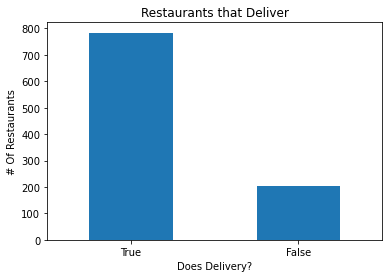

In [12]:
#The local businesses are more relevant for recruiting students that are going to live on campus.  For some, they
#may not have a car and it could be important to have businesses around that deliver
#Are there a lot of restaurants and shops that deliver?
restaurants["is_delivery"].value_counts().plot(kind='bar', title="Restaurants that Deliver", ylabel="# Of Restaurants", xlabel="Does Delivery?", rot=0);

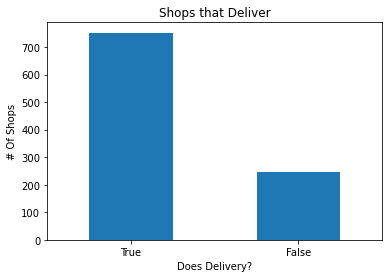

In [13]:
shops["is_delivery"].value_counts().plot(kind='bar', title="Shops that Deliver", ylabel="# Of Shops", xlabel="Does Delivery?", rot=0);

In the above two bar charts, we can see that the large majority of shops and restaurants around UMBC are available for delivery.  This kind of feature in a business could make a bigger impact being close to a college campus as some students on campus might not have a car or want to spend the money or time for an uber/taxi.  Over 300 restaurants deliver compared to under 100 that do not, and over 600 shops deliver compared to under 300 that do not.  The conclusion is that this convenience is probably appealing to a lot of students who tend to have tight schedules but also want off-campus food or need shopping essentials and an important thing to note for businesses.

In [14]:
#we could also put together a list of categories available within the 15 miles of UMBC for both restaurants
#and shops:
# here we make a function that takes in a df and returns a new df consisting of the categories and counts of each
#of those categories
def categoriesDF(dfToGetCategoriesFrom):
    categoriesFound = {}
    for index, row in dfToGetCategoriesFrom.iterrows():
        categories = row['categories'].split(', ')
        for category in categories:
            if category in categoriesFound:
                categoriesFound[category] += 1
            else:
                categoriesFound[category] = 1
    categoriesFound = {k: v for k, v in sorted(categoriesFound.items(), key=lambda item: item[1], reverse=True)}
    return pd.DataFrame(categoriesFound.items(), columns=["Category", "Number of Occurences"])

In [15]:
pd.set_option("display.max_rows", None, "display.max_columns", None) #set option to print entire dataframe
print(categoriesDF(shops))

                             Category  Number of Occurences
0              American (Traditional)                   101
1                  Breakfast & Brunch                    91
2                             Seafood                    80
3                          Sandwiches                    76
4                      American (New)                    66
5                               Pizza                    66
6                                Bars                    62
7                        Coffee & Tea                    61
8                             Italian                    57
9                          Sushi Bars                    56
10                            Mexican                    45
11                           Bakeries                    44
12                              Cafes                    40
13                           Desserts                    39
14                           Japanese                    39
15                             Indian   

In [16]:
#and for restaurants:
print(categoriesDF(restaurants))

                             Category  Number of Occurences
0              American (Traditional)                   102
1                  Breakfast & Brunch                    95
2                             Seafood                    82
3                          Sandwiches                    81
4                      American (New)                    70
5                               Pizza                    68
6                        Coffee & Tea                    65
7                                Bars                    64
8                             Italian                    59
9                          Sushi Bars                    57
10                            Mexican                    48
11                           Bakeries                    46
12                              Cafes                    45
13                             Indian                    43
14                           Desserts                    40
15                      Mediterranean   

As shown above, there are 242 different categories of shops and 143 different categories for food.  One thing I noticed was that shops and restaurants seem to overlap in the categories that they have and what yelp uses to distinguish between a "shop" and a "restaurant" may be a fuzzy line to draw sometimes.  None the less, there are so many diverse categories showing that many different kinds of shops and restaurants have the chance to be successful.  In our analysis we will try to find where there might be too much of one category, or not enough of another based on hidden patterns.

# Data Prep

In this section I prepare the data to be fed to the machine learning models.  I do things like dropping the duplicates, filling/dropping NaN values, creating dummy variables, and normalizing the data.

In [50]:
#read in the raw csv file
df = pd.read_csv("../data/scrapedData.csv", encoding= 'utf-8')

#some businesses could be part of the two different categories - drop the duplicates
df = df.drop_duplicates()

In [51]:
#First, I am going to replace all Nan values in the price column with 0's.  These null values seem like they are
#more so for things that do not have a cost associated to them, so I will represent that by using 0's
df['price'] = df['price'].fillna(0)

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,latitude,longitude,distance,address,price,is_delivery,is_pickup,category
0,HYdhgacLH57yHJ1b6TeBdQ,replay-airsoft-glen-burnie,Replay Airsoft,https://s3-media2.fl.yelpcdn.com/bphoto/hNSLVG...,False,https://www.yelp.com/biz/replay-airsoft-glen-b...,4,Airsoft,3.5,39.17365,-76.62087,11966.863685,"550 Crain Hwy N Unit 12/13 Glen Burnie, MD 21061",0.0,False,False,airsoft


In [56]:
#Next, there are some categorical variables that would be useful to have in our model - so I will create them as
#dummy variables to use them numerically.

#here we create dummy features for each of the categorical columns we see as valuable for our model
#the pandas get_dummies function returns a dataframe with the dummies used for that column
#then I concat that dataframe onto the original and drop the original column

#but first lets replace the true/false with more intuitive yes_delivery/no_delivery and yes_pickup/no_pickup
df.loc[df.is_delivery == False, "is_delivery"] = "no_delivery"
df.loc[df.is_delivery == True, "is_delivery"] = "yes_delivery"
df.loc[df.is_pickup == False, "is_pickup"] = "no_pickup"
df.loc[df.is_pickup == True, "is_pickup"] = "yes_pickup"

dummies = pd.get_dummies(df['is_delivery'])
dummyDF = pd.concat([df, dummies], axis=1).drop(['is_delivery'], axis=1)

dummies = pd.get_dummies(df['is_pickup'])
dummies = dummies.rename(columns={"False": "no_pickup", "True": "yes_pickup"})
dummyDF = pd.concat([dummyDF, dummies], axis=1).drop(['is_pickup'], axis=1) #add onto the dummies DF

dummies = pd.get_dummies(df['category'])
dummyDF = pd.concat([dummyDF, dummies], axis=1).drop(['category'], axis=1)

#Drop all the rest of the columns as they are not necessary for the model
dummyDF = dummyDF.drop(['id'], axis=1)
dummyDF = dummyDF.drop(['alias'], axis=1)
dummyDF = dummyDF.drop(['name'], axis=1)
dummyDF = dummyDF.drop(['image_url'], axis=1)
dummyDF = dummyDF.drop(['is_closed'], axis=1) #false for all the data we have
dummyDF = dummyDF.drop(['url'], axis=1)
dummyDF = dummyDF.drop(['address'], axis=1)
dummyDF = dummyDF.drop(['categories'], axis=1)

In [55]:
#Now to avoid issues where the numerical difference between numbers makes a difference in the clustering,
#since clusters are based on the distance of points from one another, I need to normalize before feeding to 
#the model.

#in order to do this we need to drop Nan rows
dummyDF = dummyDF.dropna()

#normalize the dummyDF
dummyDFScaled = normalize(dummyDF)
dummyDFScaled = pd.DataFrame(dummyDFScaled, columns=dummyDF.columns)
dummyDFScaled.head()

,review_count,rating,latitude,longitude,distance,price,no_delivery,yes_delivery,no_pickup,yes_pickup,acaibowls,acnetreatment,adultentertainment,airsoft,amateursportsteams,amusementparks,aquariums,arcades,archery,axethrowing,bagels,bakeries,barbers,bars,baseballfields,beaches,beer_and_wine,beergardens,bikerentals,bingo,boating,bowling,breweries,bubbletea,butcher,cakeshop,climbing,coffee,coffeeroasteries,comedyclubs,convenience,csa,cupcakes,customcakes,danceclubs,daycamps,desserts,discgolf,distilleries,diving,diyfood,donuts,eatertainment,empanadas,escapegames,farmersmarket,fencing,festivals,fishing,fitness,fooddeliveryservices,foodtrucks,football,galleries,gelato,gokarts,golf,gourmet,grocery,gun_ranges,hiking,honey,horsebackriding,icecream,importedfood,internetcafe,intlgrocery,juicebars,karaoke,kombucha,lasertag,massage,meaderies,mini_golf,movietheaters,musicvenues,organic_stores,paddleboarding,paintball,parks,petstore,piadinapoke,playgrounds,poolhalls,pretzels,races,rafting,recreation,restaurants,sailing,shavedice,shavedsnow,shopping,skatingrinks,smokehouse,social_clubs,spas,stadiumsarenas,streetvendors,swimmingpools,tea,tennis,theater,ticketsales,wineries
0,0.000334,0.000292,0.003273,-0.006403,0.999974,0.0,0.000084,0.0,0.000084,0.0,0.0,0.0,0.0,0.000084,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000518,0.000207,0.002040,-0.003965,0.999990,0.0,0.000052,0.0,0.000052,0.0,0.0,0.0,0.0,0.000000,0.000052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000187,0.000421,0.003675,-0.007168,0.999967,0.0,0.000094,0.0,0.000094,0.0,0.0,0.0,0.0,0.000000,0.000094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000052,0.000260,0.002034,-0.003988,0.999990,0.0,0.000052,0.0,0.000052,0.0,0.0,0.0,0.0,0.000000,0.000052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000091,0.000160,0.001784,-0.003503,0.999992,0.0,0.000046,0.0,0.000046,0.0,0.0,0.0,0.0,0.000000,0.000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling

In this section I discuss the algorithms that I will compare in the 'Model Evaluation & Selection' section.

The two main algorithms that we have taken a look at so far in class are the KMeans model and Hierarchical Clustering models.  They each have their advantages and disadvantages.

Let's begin with KMeans:

In K-Means clustering, K is the number of cluster's we will have the model look for.  Each cluster is given a centroid and the way the model works is the following: start by placing k centroids randomly, but preferably as far apart from each other as possible as the initial placement of the centroids can have an effect on the results of the algorithm (running the algorithm multiple times can help reduce this effect since it is sensitive to the initial placement).  The sklearn kmeans algorithm chooses the initial centroid placements in a smart way by default to get to convergence faster.  Next, it takes every point in the space and assign it to one of the centroids based on its euclidean distance between the centroid and observation.  From there, the centroid location is then re-calculated to be the center of all the points assigned to it.  This process is repeated until either no points change centroids or after hitting a max number of iterations.

K-Means has some weaknesses such as its sensitiveness of where the centroids are initially placed.  Also it is possible that a centroid starts out with zero data points assigned to it and so it never moves which is a problem that is generally ignored.  The biggest issue with it in our case for our business problem is in the averaging nature of the algorithm, it tends to try to make the clusters the same size.  For us, that is a bad thing as our clusters are likely not the same size.  I say this because we obviously saw many more cheaper restaurants/shops than expensive ones.  I also expect the locations of the restaurants/shops to be uneven in where they are located.  For this reason I think Hierarchical clustering might be better for us - let's take a look at it.

Hierarchical Clustering:

The main idea is this: say we have all of the n datapoints each as individual clusters so at the beginning we have n clusters.  The algorithm then combines the two most similar clusters until there is only one big cluster left which builds the hierarchy of clusters which creates a tree-like diagream that we call a dendrogram allowing us to view the clusters available for each possible number of clusters from 1 to n.  This is one advantage over k-means where we would have to set the number of clusters before the fact every time.

There are two main types of Hierarchical Clustering: agglomerative and divisive.  In agglomerative hierarchical clustering we assign each individual point to its own cluster at the beginning and then at each iteration merge the closest pair of clusters and repeat until only a single cluster is left.  Divisive works just the opposite way - starting with one single cluster of all points and splitting out the data point each iteration until each cluster only contains a single data point.  For the purpose of our project we will focus on agglomerative clustering and its types.

The types of agglomerative clustering have to do with the way we determine which two clusters are the most similar.  The 4 types are: single linkage, complete linkage, average linkage, and ward linkage.  I explain them here:

- Single linkage: takes the minimum distance between any two given points from one cluster to the other.  It is good at separating non-elliptical shapes as long as the gap between the two clusters is not small.  It is not good when there is noise between clusters.
- Complete linkage: just the opposite of single linkage - this one takes the maximum distance between any two given points from one cluster to the other.  This approach does well when there is noise between the clusters.  It does not do well when there are large clusters and tends to break them.  It tends to be biased towards globular clusters.
- Average linkage: the distance is defined as the average distance between the average values of each of the datapoints of the clusters.  It again does well when there is noise but is biased toward glbular clusters and takes the less popular approach of comparing the distances between the centroids of the clusters.
- Ward linkage: Finds the pair of clusters that leads to minimum increase in total within-cluster variance after merging at each step.  Ward's clustering technique is again good at separating when there is noise, and biased towards globular clusters.

I experiment with these algorithms below to compare and select the best one.

# Model Evaluation and Selection

In this section I will experiment with the models discussed above to evaluate and select the best one.

In [78]:
## From sklearn.cluster we will call KMeans
from sklearn.cluster import KMeans

## Some other necessary libraries
import matplotlib.pyplot as plt
import numpy as np

## to retrive some data
import pickle


## To be able to reproduce the results let's set the random_seed
%matplotlib inline

In [93]:

## let's instantiate kmeans algorithm
## don't forget to check its parameters
k_means = KMeans(n_clusters= 4)

# dont forget to fit the model!
k_means.fit(dummyDFScaled)

## we make a prediction for each point
y_hat = k_means.predict(dummyDFScaled)

## we can access the coordinates of the cluster centers by cluster_centers_ method
cl_centers = k_means.cluster_centers_

#In this case plotting it does not really make a lot of sense since there are so many dimensions.
#It is not really possible for us to visualize all of these features in a single space.
## note that the colors are different - Is this a problem?
#plt.scatter(dummyDFScaled[:,0], dummyDFScaled[:,1], c = y_hat, s = 25)


## also let's mark the cluster centers too.
#plt.scatter(cl_centers[:, 0], cl_centers[:, 1], c='black', s=100);

The above implements k-means clustering initially with 4 clusters.  One of the challenges here is to determine the number of clusters that are optimal for our model.  The technique to try to find the optimal number of clusters is the KElbowVisualizer where the elbow tends to be the optimal number of clusters.  I try this using a few different metrics to see the results.

In [70]:
import sys

!conda install --yes --prefix {sys.prefix} -c districtdatalabs yellowbrick

Solving environment: done

## Package Plan ##

  environment location: /Users/ZachV/opt/anaconda3

  added / updated specs:
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.6.20          |     pyhd3eb1b0_3         155 KB
    conda-4.9.2                |   py37hecd8cb5_0         2.9 MB
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following packages will be UPDATED:

  certifi            pkgs/main/osx-64::certifi-2020.6.20-p~ --> pkgs/main/noarch::certifi-2020.6.20-pyhd3eb1b0_3
  conda                                        4.9.0-py37_0 --> 4.9.2-py37hecd8cb5_0



conda-4.9.2          | 2.9 MB    | ##################################### | 100% 
certifi-2020.6.20    | 155 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transacti

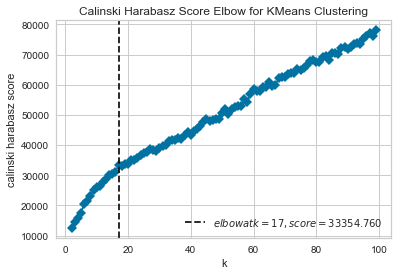

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [96]:
##  install yellowbrck library -- pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(2,100), metric = 'calinski_harabasz', timings=False)

visualizer.fit(dummyDFScaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

Based on the above, we see that the optimal number of clusters is 17.  This is where the slope of the graph appears to change and make the 'elbow'.  This metric measures the variance ratio citerion, and is the ratio of the sum of between-clusters dispersion and inter-cluster dispersion.  Generally, the higher the score the better.  The scores are better when clusters are dense and well separated and fast to compute.  We also do not want to create too many clusters to where they are all the broken out too far, hence the elbow method.  With this, we capture the optimal variance within the clusters without too many where we have a higher chance of breaking apart groups that have a lot in common. 

Next, I try the silhouette method to see its results:

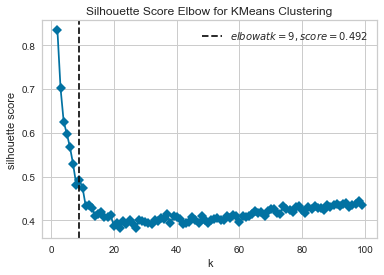

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [97]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model,
                              k=(2,100),
                              metric='silhouette', 
                              timings=False, 
                              locate_elbow=True)

visualizer.fit(dummyDFScaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

I took the same elbow approach to find the best number of clusters based on the silhouette score.  In this case the result was a little different - 9 was found to be the optimal number of clusters.  The silhouette value is a measure of how similar an object is to its own cluster compared to other clusters - so, generally the higher the score is, the better the model.  It ranges from -1 to +1 and a high score indicates that a given observation is well matched to its own cluster while being poorly matched to the surrounding clusters.  It does this by calculating the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b).  Values near zero indicate overlapping clusters while negative values generally indicate instances in the wrong cluster as a different cluster is more similar.  Obiously, if the number of clusters is set to be small, the datapoints inside will match that cluster well since there will be a lot there and not match the other as well but this does not necessarily reveal an optimal amount of information as breaking the groups out further could tell us more information.  That is again why the elbow method is used here.  This would tell us that there are optimally 9 different groups of businesses in our dataset.  This metric is a good choice for our problem because it is exactly a measure that we want - we want all of what is in a cluster to be similar while different from the other clusters.  It also provides a more obvious elbow.  The one in the chart for calinski harabasz isn't as defined and clear.  So, the optimal 9 clusters in this case looks like we can be a little more confident that it is the optimal number of clusters from the silhouette score.  The drawback is that it takes longer to compute, but for our amount of data it is not that big of a deal.  So, we will use the 9 clusters as our optimal number for the kmeans algorithm.

Next, we look at hierachial clustering:

In [99]:
#Lets try some Hierarchical Clustering
#First start by creating a dendrogram

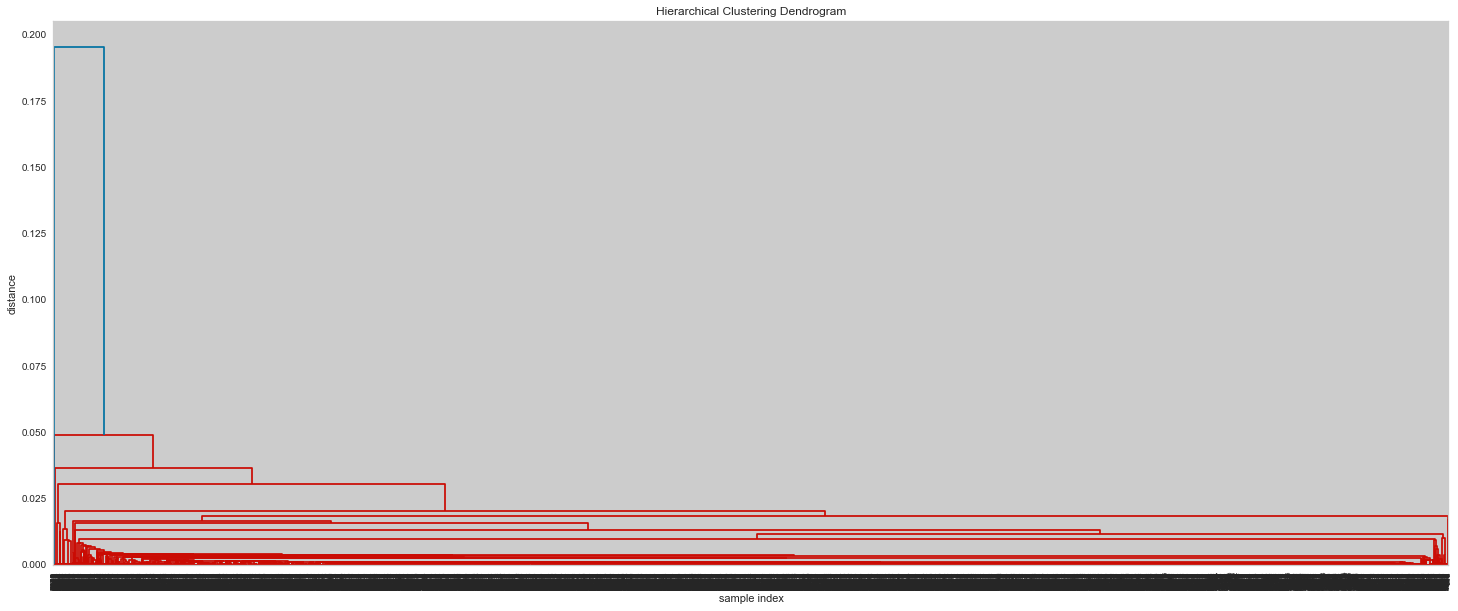

In [83]:
# calculate and construct the dendrogram 
# calculate full dendrogram
#NOTE: this may take a long time to calculate and display and may not be too interpretable.  The truncated version
#in the next code cell is better.

plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

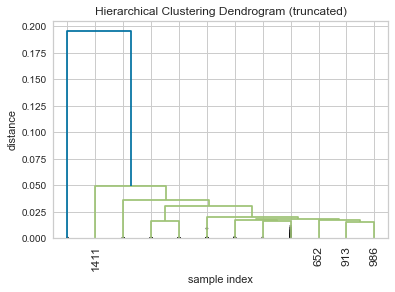

In [82]:
# trimming and truncating the dendrogram 
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

The truncated dendrogram above shows the higher level for the clusters created.  If I make the x-axis the cutoff and draw a horizontal line there, it would result in there being 12 clusters.  Visually, this looks like the optimal number for the hierachial clustering.

Let's see the results for each type of agglomerative clustering:

In [104]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [108]:
#using ward:
cluster = AgglomerativeClustering(n_clusters=12, linkage="ward")
pred_business_clust = cluster.fit_predict(dummyDFScaled)
# evaluation - silhouette score 
silhouette_score(dummyDFScaled, pred_business_clust)

0.4389333770739532

In [109]:
#using complete
cluster = AgglomerativeClustering(n_clusters=12, linkage="complete")
pred_business_clust = cluster.fit_predict(dummyDFScaled)
# evaluation - silhouette score 
silhouette_score(dummyDFScaled, pred_business_clust)

0.5865630099854366

In [110]:
#using average
cluster = AgglomerativeClustering(n_clusters=12, linkage="average")
pred_business_clust = cluster.fit_predict(dummyDFScaled)
# evaluation - silhouette score 
silhouette_score(dummyDFScaled, pred_business_clust)

0.6358478568835271

In [113]:
#using single
cluster = AgglomerativeClustering(n_clusters=12, linkage="single")
pred_business_clust = cluster.fit_predict(dummyDFScaled)
# evaluation - silhouette score 
silhouette_score(dummyDFScaled, pred_business_clust)

0.6628091652828773

In [114]:
#using single with 9 clusters for k-means comparison
cluster = AgglomerativeClustering(n_clusters=9, linkage="single")
pred_business_clust = cluster.fit_predict(dummyDFScaled)
# evaluation - silhouette score 
silhouette_score(dummyDFScaled, pred_business_clust)

0.6965727610711406

Based on the above results, we see that for agglomerative clustering using the number of clusters as 12 gives us an optimal silhouette of 0.66 and comes when we use the 'single' linkage method.  Compared to the results for k-means, this is way better.  If we turn the number of clusters down to 9 here to compare the silhouette score result with that of k-means, for agglomerative clustering using the 'single' linkage we get a silhouette score of 0.697 compared to the 0.492 we saw using k-means for a increase of over 0.2.  This was again somewhat expected as we know that k-means likes to try to make clusters the same size and in our case the clusters are most definitely going to need to be different sizes to be the most accurate as there are more of some types of businesses than others like more cheap restaurants than expensive ones.  

For our optimal model - we will pick agglomerative clustering using 12 clusters and the 'single' linkage.

Next we need to analyze for the hidden groups of businesses based off of our cluster model:

In [116]:
#create a new column for the cluster predictions:
cluster = AgglomerativeClustering(n_clusters=12, linkage="single")
dummyDFScaled['cluster-label'] = cluster.fit_predict(dummyDFScaled)
dummyDFScaled.head()

,review_count,rating,latitude,longitude,distance,price,no_delivery,yes_delivery,no_pickup,yes_pickup,acaibowls,acnetreatment,adultentertainment,airsoft,amateursportsteams,amusementparks,aquariums,arcades,archery,axethrowing,bagels,bakeries,barbers,bars,baseballfields,beaches,beer_and_wine,beergardens,bikerentals,bingo,boating,bowling,breweries,bubbletea,butcher,cakeshop,climbing,coffee,coffeeroasteries,comedyclubs,convenience,csa,cupcakes,customcakes,danceclubs,daycamps,desserts,discgolf,distilleries,diving,diyfood,donuts,eatertainment,empanadas,escapegames,farmersmarket,fencing,festivals,fishing,fitness,fooddeliveryservices,foodtrucks,football,galleries,gelato,gokarts,golf,gourmet,grocery,gun_ranges,hiking,honey,horsebackriding,icecream,importedfood,internetcafe,intlgrocery,juicebars,karaoke,kombucha,lasertag,massage,meaderies,mini_golf,movietheaters,musicvenues,organic_stores,paddleboarding,paintball,parks,petstore,piadinapoke,playgrounds,poolhalls,pretzels,races,rafting,recreation,restaurants,sailing,shavedice,shavedsnow,shopping,skatingrinks,smokehouse,social_clubs,spas,stadiumsarenas,streetvendors,swimmingpools,tea,tennis,theater,ticketsales,wineries,cluster-label
0,0.000334,0.000292,0.003273,-0.006403,0.999974,0.0,0.000084,0.0,0.000084,0.0,0.0,0.0,0.0,0.000084,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.000518,0.000207,0.002040,-0.003965,0.999990,0.0,0.000052,0.0,0.000052,0.0,0.0,0.0,0.0,0.000000,0.000052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.000187,0.000421,0.003675,-0.007168,0.999967,0.0,0.000094,0.0,0.000094,0.0,0.0,0.0,0.0,0.000000,0.000094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.000052,0.000260,0.002034,-0.003988,0.999990,0.0,0.000052,0.0,0.000052,0.0,0.0,0.0,0.0,0.000000,0.000052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.000091,0.000160,0.001784,-0.003503,0.999992,0.0,0.000046,0.0,0.000046,0.0,0.0,0.0,0.0,0.000000,0.000046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


# Conclusions, Interpretations, Limitations, and Later Work

Some of the conclusions relevant to determining the hidden groups within businesses around UMBC:
 - The optimal model we found was an agglomerative cluster using 12 clusters - so 12 different groups of similar businesses.  We could potentially play more with this in the future to see if we can get more out of using a higher or lower number of clusters.
 - The shops and restaurants surrounding campus are very affordable.  Students coming to live on campus and pay the room and board fee will probably look to save in other areas and here we show the price level for most shops and restaurants is either inexpensive or moderate.
 - The large majority of shops and restaurants around campus deliver.  Living on campus without a car?  No problem at all just use the delivery services of these local shops and places to eat.
 - The options for shops and food around campus are so diverse - attracting prospective students from across the world.  With over 240 different categories of shops and over 140 different kinds of food to eat, there is something local around UMBC for just about everyone.
 
In conclusion, we have lots of stats and information that UMBC can advertise on flyers or their website to potential incoming students to encourage them/ give them reasons to attend UMBC.  I think the above findings are a good start to answering the question and when more time allows and after more research in what facts have the biggest impact on prospective students' decisions we can do even better at collecting information that will prove extremely helpful in recruiting the most talented students to UMBC.  The number of stats or information and ways to display that information are really endless and it will take time to find the optimal absolute best solution.